<h1 align='center'>Time-Series-Prediction-with-Deep-Learning</h1>

## imports

In [4]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset
We'll take advantage of pandas' built-in <a href='https://pandas.pydata.org/pandas-docs/stable/timeseries.html'>DatetimeIndex</a> by passing <tt>parse_dates=True</tt>

In [5]:
df = pd.read_csv('data/Alcohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

325

In [6]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

325

In [7]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [8]:
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


## Plot the time series

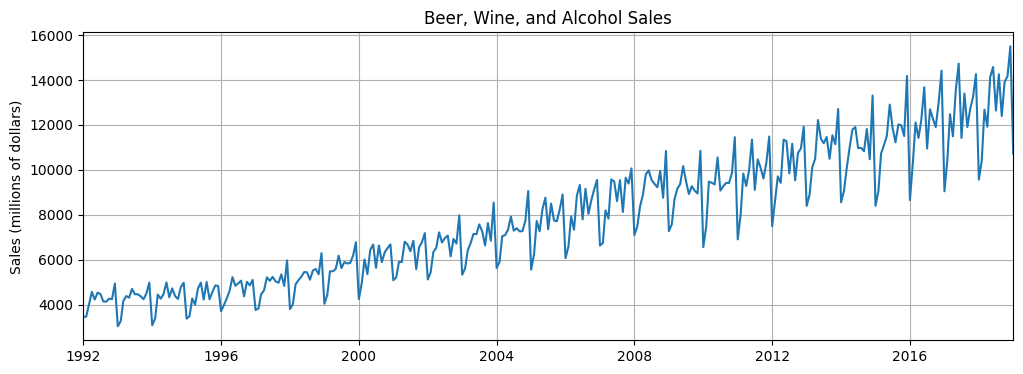

In [9]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Data preparartion
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [10]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [11]:
print(f"shape of train_set : {train_set.shape}")
print(f"shape of test_set : {test_set.shape}")

shape of train_set : (313,)
shape of test_set : (12,)


It's worth noting that in our previous exercise the train and test sets were tensors. Here they're numpy arrays. This is because one of the steps we're about to perform outputs an array, and we'd have to turn it into a tensor anyway.

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [13]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [14]:
train_norm[:10]

array([[-0.92683135],
       [-0.92700231],
       [-0.83400291],
       [-0.73792632],
       [-0.79656381],
       [-0.74390974],
       [-0.75467989],
       [-0.81092401],
       [-0.81280451],
       [-0.79006753]])

## Data preparation for LSTM training

Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [15]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq, ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [16]:
train_data[:2]

[(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
          -0.8128, -0.7901, -0.7933, -0.6743]),
  tensor([-1.])),
 (tensor([-0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109, -0.8128,
          -0.7901, -0.7933, -0.6743, -1.0000]),
  tensor([-0.9607]))]

## Define the model

We will be using an LSTM layer of size (1, 1000).

In [17]:
class SalesPredictor(nn.Module):

    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1, 1, self.hidden_size),
                       torch.zeros(1, 1, self.hidden_size))
    def forward(self, seq):
        out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(out.view(len(seq), -1))
        return pred[-1]

## Instantiate the model and define the loss and optimizer

In [18]:
predictorModel = SalesPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(predictorModel.parameters(), lr=0.001)

predictorModel

SalesPredictor(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

## Model's training

In [19]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        predictorModel.hidden = (torch.zeros(1,1,predictorModel.hidden_size),
                        torch.zeros(1,1,predictorModel.hidden_size))
        
        y_pred = predictorModel(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.32617387
Epoch:  2 Loss: 0.27362490
Epoch:  3 Loss: 0.41979903
Epoch:  4 Loss: 0.32246235
Epoch:  5 Loss: 0.31794178
Epoch:  6 Loss: 0.31916291
Epoch:  7 Loss: 0.31633398
Epoch:  8 Loss: 0.32046348
Epoch:  9 Loss: 0.27729741
Epoch: 10 Loss: 0.31430683
Epoch: 11 Loss: 0.25991124
Epoch: 12 Loss: 0.29677722
Epoch: 13 Loss: 0.29395819
Epoch: 14 Loss: 0.24540330
Epoch: 15 Loss: 0.28595659
Epoch: 16 Loss: 0.24426153
Epoch: 17 Loss: 0.27708814
Epoch: 18 Loss: 0.18455352
Epoch: 19 Loss: 0.12505092
Epoch: 20 Loss: 0.16627307
Epoch: 21 Loss: 0.27786869
Epoch: 22 Loss: 0.02248461
Epoch: 23 Loss: 0.01452922
Epoch: 24 Loss: 0.03610012
Epoch: 25 Loss: 0.01298020
Epoch: 26 Loss: 0.00000799
Epoch: 27 Loss: 0.02521623
Epoch: 28 Loss: 0.01243191
Epoch: 29 Loss: 0.02242710
Epoch: 30 Loss: 0.14453921
Epoch: 31 Loss: 0.00429274
Epoch: 32 Loss: 0.00168152
Epoch: 33 Loss: 0.00666165
Epoch: 34 Loss: 0.00521666
Epoch: 35 Loss: 0.00509977
Epoch: 36 Loss: 0.00304067
Epoch: 37 Loss: 0.00162668
E

## Model's inference

In [20]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
predictorModel.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        predictorModel.hidden = (torch.zeros(1,1,predictorModel.hidden_size),
                        torch.zeros(1,1,predictorModel.hidden_size))
        preds.append(predictorModel(seq).item())

In [21]:
preds[window_size:]  

[0.23748889565467834,
 0.36932146549224854,
 0.5530648231506348,
 0.6728824973106384,
 0.9795597791671753,
 0.45929068326950073,
 0.7306860685348511,
 0.529274582862854,
 0.6295269131660461,
 0.6828604936599731,
 1.0080056190490723,
 0.05758325755596161]

Let's invert the prediction so that we can compare them with original values in test sets.

Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [22]:
true_prediction = scaler.inverse_transform(np.array(preds[window_size:]).reshape(1, -1))
true_prediction = true_prediction.squeeze()

In [23]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [24]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

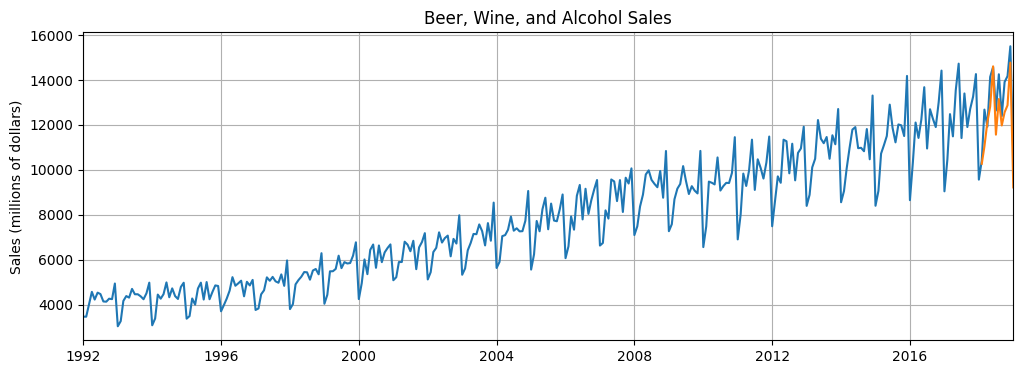

In [25]:
    plt.figure(figsize=(12,4))
    plt.title('Beer, Wine, and Alcohol Sales')
    plt.ylabel('Sales (millions of dollars)')
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.plot(df['S4248SM144NCEN'])
    plt.plot(x,true_prediction)
    plt.show()

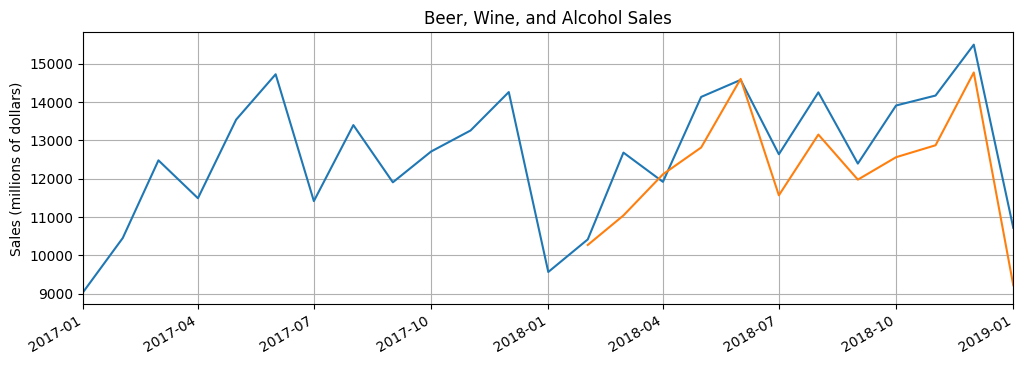

In [26]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_prediction)
plt.show()

In [28]:
train_norm

tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
        -0.8128, -0.7901, -0.7933, -0.6743, -1.0000, -0.9607, -0.8070, -0.7699,
        -0.7819, -0.7154, -0.7560, -0.7562, -0.7721, -0.7940, -0.7489, -0.6678,
        -0.9925, -0.9408, -0.7586, -0.7897, -0.7557, -0.6660, -0.7790, -0.7114,
        -0.7704, -0.7919, -0.7003, -0.6683, -0.9420, -0.9226, -0.7884, -0.8354,
        -0.7121, -0.6678, -0.7962, -0.6634, -0.7942, -0.7396, -0.6889, -0.6931,
        -0.8858, -0.8373, -0.7896, -0.7285, -0.6260, -0.6914, -0.6735, -0.6528,
        -0.7719, -0.6613, -0.6890, -0.6468, -0.8757, -0.8643, -0.7567, -0.7258,
        -0.6275, -0.6536, -0.6239, -0.6576, -0.6685, -0.6049, -0.6923, -0.4984,
        -0.8692, -0.8311, -0.6808, -0.6480, -0.6229, -0.5870, -0.5890, -0.6451,
        -0.5753, -0.5637, -0.6042, -0.4435, -0.8289, -0.7600, -0.5815, -0.5808,
        -0.5630, -0.4623, -0.5572, -0.5114, -0.5218, -0.5182, -0.4617, -0.3606,
        -0.7928, -0.6716, -0.4911, -0.60